In [36]:
%reset -f
import sys
sys.path.append('/home/psimmerl/mds_analysis')

import pathlib

import math
import numpy as np
import numba as nb
from math import ceil, floor

from src.histo_utilities import std_color_list as SCL
# from src.helper_functions import alert, Table, weight_calc

from src import CMS_lumi, tdrstyle
root_style = tdrstyle.setTDRStyle()

import ROOT as rt
from ROOT import RDataFrame
from ROOT import TCanvas, TLatex, TLegend, TLine, TBox
from ROOT import TH1D, TH2D, TGraph, TGraphErrors, TGraphAsymmErrors


# **************************** #
LOCAL_DIR = '/home/psimmerl/mds_analysis'
OUT_DIR = f'{LOCAL_DIR}/reports/weekly/2024-04-15'

# **** #
MET_CATEGORY = ('lt200', 'low', 'high')[1]
TAG_CATEGORY = ('csccsc', 'cscdt')[0]
# CUTSET = ('l1', 'scs', 'ropt', 'roptDNN', 'roptDNN_bkgMC_plusBeamHalo', 'tightDNN')[5]
CUTSET = ('l1', 'scs', 'ropt', 'roptDNN', 'roptDNN_bkgMC_plusBeamHalo', 'tightDNN')[2]
OOT = False#True#

SIZE_VAR = TAG_CATEGORY[3:]

FN_MC = f'{LOCAL_DIR}/data/processed/mc_{TAG_CATEGORY}_{CUTSET}_{MET_CATEGORY}_rdf.root'
# FN_MC = f'{LOCAL_DIR}/data/processed/mc_{TAG_CATEGORY}{"OOT" if OOT else ""}_{CUTSET}_{MET_CATEGORY}_rdf.root'
FN_R3 = f'{LOCAL_DIR}/data/processed/r3_{TAG_CATEGORY}{"OOT" if OOT else ""}_{CUTSET}_{MET_CATEGORY}_rdf.root'

# **** #
# STANDARD CUT SELECTION
if CUTSET == 'scs':
    if TAG_CATEGORY == 'csccsc':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'high':
            ABCD_DPHI = None
            ABCD_SIZE = None

    if TAG_CATEGORY == 'cscdt':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = 2.65
            ABCD_SIZE = 134
        if MET_CATEGORY == 'high':
            ABCD_DPHI = 1.40
            ABCD_SIZE = 128

if CUTSET == 'ropt':
    if TAG_CATEGORY == 'csccsc':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'high':
            ABCD_DPHI = None
            ABCD_SIZE = None

    if TAG_CATEGORY == 'cscdt':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = 2.75
            ABCD_SIZE = 81
        if MET_CATEGORY == 'high':
            ABCD_DPHI = 1.8
            ABCD_SIZE = 73

if CUTSET == 'roptDNN':
    if TAG_CATEGORY == 'csccsc':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'high':
            ABCD_DPHI = None
            ABCD_SIZE = None

    if TAG_CATEGORY == 'cscdt':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'high':
            ABCD_DPHI = None
            ABCD_SIZE = None

if CUTSET == 'roptDNN_bkgMC_plusBeamHalo':
    if TAG_CATEGORY == 'csccsc':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'high':
            ABCD_DPHI = None
            ABCD_SIZE = None

    if TAG_CATEGORY == 'cscdt':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'high':
            ABCD_DPHI = None
            ABCD_SIZE = None

if CUTSET == 'tightDNN':
    if TAG_CATEGORY == 'csccsc':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'high':
            ABCD_DPHI = None
            ABCD_SIZE = None

    if TAG_CATEGORY == 'cscdt':
        if MET_CATEGORY == 'lt200':
            ABCD_DPHI = None
            ABCD_SIZE = None
        if MET_CATEGORY == 'low':
            ABCD_DPHI = 2.75
            ABCD_SIZE = 131
        if MET_CATEGORY == 'high':
            ABCD_DPHI = None
            ABCD_SIZE = None

# **** #
pathlib.Path(OUT_DIR).mkdir(parents=True, exist_ok=True)

# rt.gErrorIgnoreLevel = 1001  # rt.kInfo + 1
# rt.gROOT.SetBatch(True)
PI = rt.TMath.Pi()

# rt.EnableImplicitMT(4)
# print('Enabled ROOT\'s implicit multithreading (sometimes causes a crash)')

gc = []

# **************** #
print(f'{MET_CATEGORY=}')
print(f'{TAG_CATEGORY=}')
print(f'{CUTSET=}')
print(f'{OOT=}')
print('')

print(f'{ABCD_DPHI=}')
print(f'{ABCD_SIZE=}')
print('')

print(f'{FN_MC=}')
print(f'{FN_R3=}')
print(f'{OUT_DIR=}')
print('')

# **************** #
rdfs = {
    'mc' : RDataFrame('MuonSystem_flat', FN_MC),
    'r3' : RDataFrame('MuonSystem_flat', FN_R3),
}

print('Events Read:')
for key, rdf in rdfs.items():
    if TAG_CATEGORY == 'csccsc':
        # rdf = rdf.Filter('tag_dR > 1.5')
        rdf = rdf.Alias('tag_size', 'csc1Size')
        rdf = rdf.Alias('tag_ctau', 'csc1CTau')

    if TAG_CATEGORY == 'cscdt':
        # rdf = rdf.Filter('tag_dPhi > 0.4')
        rdf = rdf.Alias('tag_size', 'dtSize')
        rdf = rdf.Alias('tag_ctau', 'dtCTau')

    count, weight = rdf.Count().GetValue(), rdf.Sum('weight').GetValue()
    print(f'  {key} = {count:,} ({weight:,.2f})')

    rdfs[key] = rdf


MET_CATEGORY='low'
TAG_CATEGORY='csccsc'
CUTSET='ropt'
OOT=True

ABCD_DPHI=None
ABCD_SIZE=None

FN_MC='/home/psimmerl/mds_analysis/data/processed/mc_csccsc_ropt_low_rdf.root'
FN_R3='/home/psimmerl/mds_analysis/data/processed/r3_csccscOOT_ropt_low_rdf.root'
OUT_DIR='/home/psimmerl/mds_analysis/reports/weekly/2024-04-15'

Events Read:
  mc = 1,334 (973.89)
  r3 = 564 (564.00)


In [38]:
rdfs['r3'].Histo1D('nCsc')

TypeError: Template method resolution failed:
  none of the 4 overloaded methods succeeded. Full details:
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Histo1D(basic_string_view<char,char_traits<char> > vName) =>
    runtime_error: Unknown column: "nCsc"
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Histo1D(const ROOT::RDF::TH1DModel& model, basic_string_view<char,char_traits<char> > vName, basic_string_view<char,char_traits<char> > wName) =>
    TypeError: takes at least 3 arguments (1 given)
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Histo1D(basic_string_view<char,char_traits<char> > vName, basic_string_view<char,char_traits<char> > wName) =>
    TypeError: takes at least 2 arguments (1 given)
  ROOT::RDF::RResultPtr<TH1D> ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager,void>::Histo1D(const ROOT::RDF::TH1DModel& model = {"", "", 128U, 0., 0.}, basic_string_view<char,char_traits<char> > vName = "") =>
    TypeError: could not convert argument 1

In [ ]:
if 'OOT' not in FN_R3:
    raise Warning('data is not OOT!')

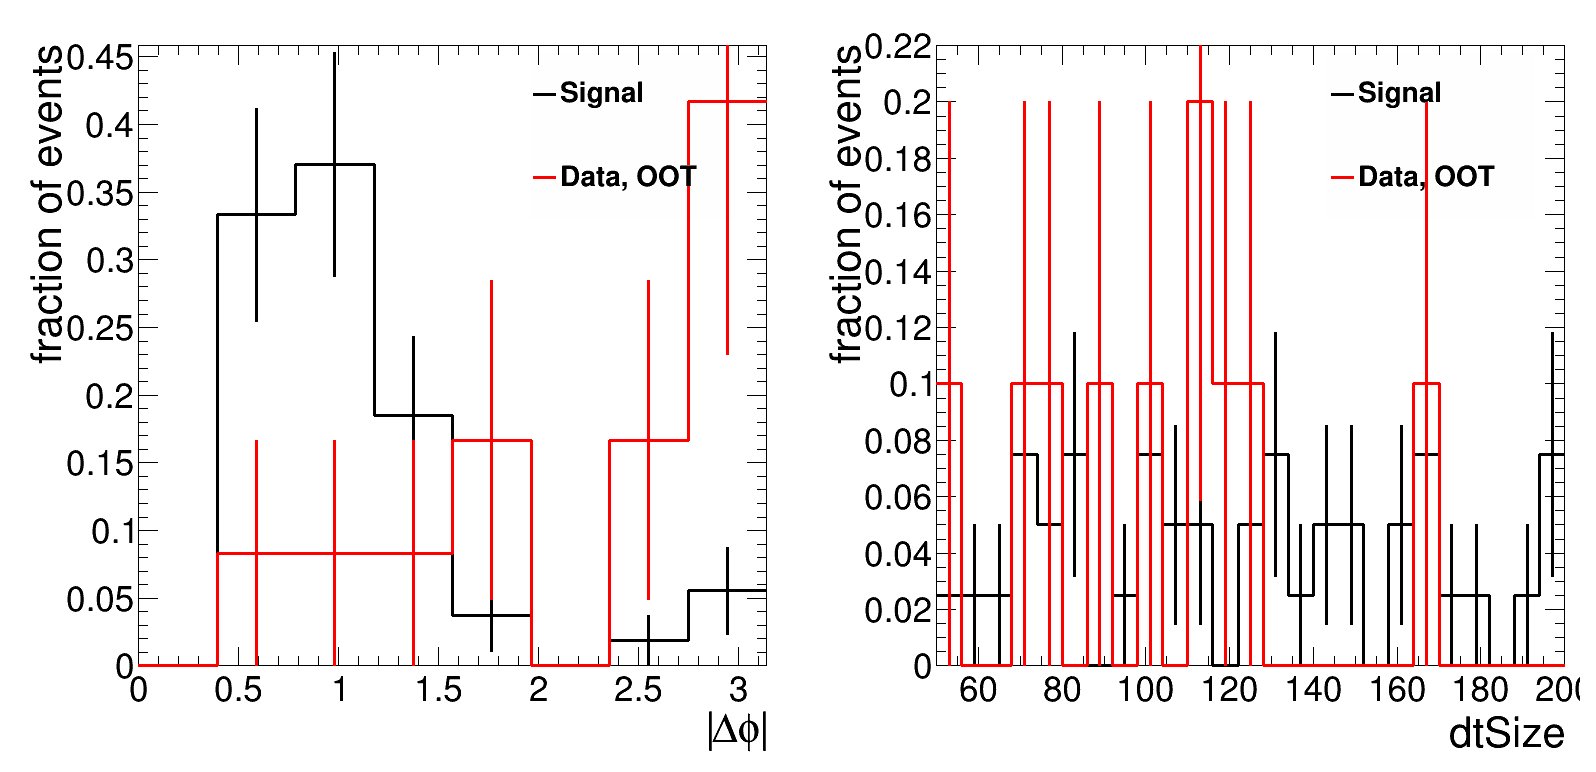

In [ ]:
canvas = TCanvas('','',2*800,800)
canvas.Divide(2,1)
canvas.SetGrid()

hinfos = { 
    'tag_dPhi' : {
        'form' : (f';|#Delta#phi|;fraction of events',32,0,np.pi),
        'form' : (f';|#Delta#phi|;fraction of events',16,0,np.pi),
        'form' : (f';|#Delta#phi|;fraction of events',8,0,np.pi),
    },
   'dtSize' : {
        'form' : (f';dtSize;fraction of events',25,50,200),
        # 'form' : (f';dtSize;fraction of events',25,65,100),
        # 'form' : (f';dtSize;fraction of events',15,50,80),
        # 'form' : (f';dtSize;fraction of events',10,50,80),
        # 'form' : (f';dtSize;fraction of events',25,50,500),
    },
    # 'csc0Phi' : {
    #     'form' : (f';#phi_{{var}};fraction of events',32,0,np.pi),
    # },
}

for ixv, (xv, hinfo) in enumerate(hinfos.items()):
    canvas.cd(ixv+1)
    # canvas.cd(ixv+1).SetLogy()
    form = hinfo['form']

    # **** #
    legend = TLegend(0.67, 0.72, 0.94, 0.94)
    legend.SetBorderSize(0)
    legend.SetFillColorAlpha(rt.kBlack, 0.0)#0.2)
    legend.SetTextSize(0.04)
    legend.SetMargin(0.15)


    # **** #

    h1 = rdfs['mc'].Histo1D(('Signal',*form),xv,).GetValue()
    h2 = rdfs['r3'].Histo1D(('Data'+(', OOT' if OOT else ''),*form),xv,).GetValue()

    hhs = [h1,h2]
    # hmax = max([h.GetMaximum() for h in hhs])
    hmax = max([h.GetMaximum() / h.Integral() if h.Integral() else 0 for h in hhs])
    for ih, hh in enumerate(hhs):
        nev = hh.Integral()
        if hmax < 1 and nev:
            hh.Scale(1/hh.Integral())
        hh.SetMinimum(0)
        hh.SetMaximum(hmax*1.1)
        hh.SetLineColor(SCL[ih])
        hh.SetLineWidth(3)
        hh.Draw('histe same')
        legend.AddEntry(hh, hh.GetName(), 'L')


    legend.Draw()
    gc.extend([legend]+hhs)
canvas.Draw()


# ABCD Optimization


In [ ]:
# from scipy.optimize import minimize, basinhopping
# from scipy.stats import poisson, expon#, gamma
# from scipy.special import gamma, loggamma


# wt_mc = rdfs['mc'].AsNumpy(['weight','tag_dPhi','tag_size'])
# wt_mc, dp_mc, sz_mc = wt_mc['weight'], wt_mc['tag_dPhi'], wt_mc['tag_size']

# wt_r3 = rdfs['r3'].AsNumpy(['weight','tag_dPhi','tag_size'])
# wt_r3, dp_r3, sz_r3 = wt_r3['weight'], wt_r3['tag_dPhi'], wt_r3['tag_size']
# wt_r3 = 73/np.sum(wt_r3)*wt_r3

# rng = np.random.default_rng()#seed=0)

# def abcd_likelihood(pars, sig, obs):
#     def pois(o, n, log=True):
#         if log:
#             return o*np.log(n) - n# - loggamma(o+1)
#         return n**o * np.exp(-1*n) / gamma(o+1)
#     c1, c2, bkgc, mu = pars
#     # bkgb, bkgc, bkgd, mu = pars
#     sig_a, sig_b, sig_c, sig_d = sig
#     obs_a, obs_b, obs_c, obs_d = obs

#     # bkga = bkgb*bkgd/bkgc
#     # bkgbe = bkga * (1/bkgb + 1/bkgc + 1/bkgd)**0/5

#     N_a = c1*c2*bkgc + mu*sig_a # bkga + mu*sig_a # 
#     N_b = c1*bkgc + mu*sig_b # bkgb + mu*sig_b # 
#     N_c = bkgc + mu*sig_c # bkgc + mu*sig_c # 
#     N_d = c2*bkgc + mu*sig_d # bkgd + mu*sig_d # 
#     # print(N_a, obs_a, poisson.pmf(obs_a, round(N_a)))
#     # print(N_b, obs_b, poisson.pmf(obs_b, round(N_b)))
#     # print(N_c, obs_c, poisson.pmf(obs_c, round(N_c)))
#     # print(N_d, obs_d, poisson.pmf(obs_d, round(N_d)))
#     # print('')
#     p = lambda o, n: poisson.logpmf(np.round(o), n) # pois(o, n)#
#     return -( p(obs_a, N_a) + p(obs_b, N_b) + p(obs_c, N_c) + p(obs_d, N_d) )
#     # return -100 * ( p(obs_a, N_a) * p(obs_b, N_b) * p(obs_c, N_c) * p(obs_d, N_d) )**(1/4)

# dp_szs = [[round(dp,2),int(sz)] for dp in np.arange(1.0, 3.15+0.05, 0.05) for sz in np.arange(60,150+1,1)]

# bounds, results = [], []
# best_bounds, best_res, best_mu = None, None, np.inf
# for iter in range(len(dp_szs)):#range(1000):
#     if len(dp_szs) == 0:
#         break
#     # dp, sz = 2.75, 81
#     # while [dp, sz] in bounds:
#     #     dp = round(rng.uniform(0.4, np.pi),2)
#     #     sz = round(rng.uniform(50, 150))
#     dp, sz = rng.choice(dp_szs)
#     dp_szs.remove([dp,sz])

#     a_mc = np.sum(wt_mc[(dp_mc >= dp) & (sz_mc >= sz)])
#     b_mc = np.sum(wt_mc[(dp_mc >= dp) & (sz_mc < sz)])
#     c_mc = np.sum(wt_mc[(dp_mc < dp) & (sz_mc < sz)])
#     d_mc = np.sum(wt_mc[(dp_mc < dp) & (sz_mc >= sz)])

#     a_r3 = np.sum(wt_r3[(dp_r3 >= dp) & (sz_r3 >= sz)])
#     b_r3 = np.sum(wt_r3[(dp_r3 >= dp) & (sz_r3 < sz)])
#     c_r3 = np.sum(wt_r3[(dp_r3 < dp) & (sz_r3 < sz)])
#     d_r3 = np.sum(wt_r3[(dp_r3 < dp) & (sz_r3 >= sz)])

#     # a_r3 = rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {sz})').Sum('weight')
#     # b_r3 = rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {sz})').Sum('weight')
#     # c_r3 = rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {sz})').Sum('weight')
#     # d_r3 = rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {sz})').Sum('weight')
#     # a_r3, b_r3, c_r3, d_r3 = a_r3.GetValue(), b_r3.GetValue(), c_r3.GetValue(), d_r3.GetValue()

#     if b_r3 == 0 or c_r3 == 0 or d_r3 == 0:# or b_mc == 0 or c_mc == 0 or d_mc == 0:
#         bounds.append([dp, sz])
#         results.append(None)
#         continue

#     # a_mc = rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {sz})').Sum('weight')
#     # b_mc = rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {sz})').Sum('weight')
#     # c_mc = rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {sz})').Sum('weight')
#     # d_mc = rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {sz})').Sum('weight')
#     # a_mc, b_mc, c_mc, d_mc = a_mc.GetValue(), b_mc.GetValue(), c_mc.GetValue(), d_mc.GetValue()

#     ap_r3 = b_r3*d_r3/c_r3
#     ape_r3 = ap_r3*(1/b_r3 + 1/c_r3 + 1/d_r3)**0.5
#     # if abs(a_r3-ap_r3)/((a_r3**0.5 + ape_r3)**0.5) > 1:
#     #     bounds.append([dp, sz])
#     #     results.append(None)
#     #     continue
#     a_r3 = ap_r3

#     c1, c2, bkgc = b_r3/c_r3, d_r3/c_r3, c_r3
#     mu = ((3/2 + ap_r3**0.5)**2 - ap_r3)/a_mc
#     # mu = min(mu,1)
#     cl_constraint = {
#         'type': 'eq',
#         # 'fun' : lambda x: 3 - x[3]*a_mc / ( (x[0]*x[2]/x[1])**0.5 ),
#         # 'fun' : lambda x: 3 - x[3]*a_mc / ( x[0]*x[2]/x[1]*(1/x[0]+1/x[1]+1/x[2])**0.5 ),
#         # 'fun' : lambda x: 3 - 2*( (a_r3)**0.5 - (x[0]*x[1]*x[2])**0.5 )
#         'fun' : lambda x: 3 - 2*( (x[0]*x[1]*x[2] + x[3]*a_mc)**0.5 - (x[0]*x[1]*x[2])**0.5 ),
#         # 'fun' : lambda x: 3 - 2*( (a_r3 + x[3]*a_mc)**0.5 - (a_r3)**0.5 ),
#         # 'fun' : lambda x: 3 - x[3]*a_mc / (x[0]*x[1]*x[2])**0.5,
#         # 'fun' : lambda x: 3 - x[3]*a_mc / (a_r3)**0.5,
#         # 'fun' : lambda x: 3 - 2*( (a_r3)**0.5 - (x[0]*x[2]/x[1])**0.5 )
#         # 'fun' : lambda x: 3 - 2*( (x[0]*x[2]/x[1] + x[3]*a_mc)**0.5 - (x[0]*x[2]/x[1])**0.5 )
#         # 'fun' : lambda x: 3 - 2*( (x[0]*x[2]/x[1] + x[3]*a_mc)**0.5 - x[0]*x[2]/x[1]*(1/x[0]+1/x[1]+1/x[2])**0.5 )
#         # 'fun' : lambda x: 3 - 2*( ((x[0]*x[2]/x[1]*(1/x[0]+1/x[1]+1/x[2])**0.5)**2 + x[3]*a_mc)**0.5 - x[0]*x[2]/x[1]*(1/x[0]+1/x[1]+1/x[2])**0.5 )
#         # 'fun' : lambda x: 3 - 2*( (a_r3)**0.5 - x[0]*x[2]/x[1]*(1/x[0]+1/x[1]+1/x[2])**0.5 )
#         # 'fun' : lambda x: 3 - 2*( ape_r3 - x[0]*x[2]/x[1]*(1/x[0]+1/x[1]+1/x[2])**0.5 )
#     }

#     res = minimize(
#     # res = basinhopping(
#         abcd_likelihood,
#         x0=(c1, c2, bkgc, 1),#mu),#(b_r3, c_r3, d_r3, mu),#
#         args=((a_mc, b_mc, c_mc, d_mc), (a_r3, b_r3, c_r3, d_r3)),
#         # method='SLSQP',#'trust-constr',#'Nelder-Mead',
#         bounds=(
#             (c1/100, c1*100),#(1e-9, 7*b_r3),#
#             (c2/100, c2*100),#(1e-9, 7*c_r3),#
#             (bkgc/10, bkgc*10),#(1e-9, 7*d_r3),#
#             (0, None),
#         ),
#         constraints=cl_constraint,
#         options={'maxiter' : 1000},
#         # minimizer_kwargs={
#         #     'args':  ((a_mc, b_mc, c_mc, d_mc), (a_r3, b_r3, c_r3, d_r3)),
#         #     'bounds' : (
#         #         (0, 3*b_r3),#c1),
#         #         (1, 3*c_r3),#c2),
#         #         (0, 3*d_r3),#bkgc),
#         #         (0, 1),
#         #     ),
#         #     'constraints' : cl_constraint,
#         # },
#         # niter=20,
#     )
#     bounds.append([dp, sz])
#     results.append(res)
#     if res.success and res.x[-1] < best_mu and res.x[-1] > 0:
#         best_bounds = (dp, sz)
#         best_res = res
#         best_mu = res.x[-1]
#         c1, c2, bkgc, mu = res.x
#         # bkgb, bkgc, bkgd, mu = res.x
#         bkgb, bkgd = c1*bkgc, c2*bkgc
#         bkga, bkgae = bkgb*bkgd/bkgc, bkgb*bkgd/bkgc*(1/bkgb + 1/bkgc + 1/bkgd)**0.5
#         s12_sbb = 2*((bkga + mu*a_mc)**0.5 - bkga**0.5)
#         s12_r3b = 2*((a_r3)**0.5 - bkga**0.5)
#         print(f'n iters, neg log-likelihood = {res.nit:>4.0f}, {res.fun:>6.3f}')
#         # print(f'dphi, size = {dp:>4.2f}, {sz:>3.0f}')
#         # print(f'c1, c2, mu = {c1:>5.3f}, {c2:>5.3f}, {mu:.3e}')
#         print(f'dphi, size, mu = {dp:>4.2f}, {sz:>3.0f}, {mu:.3e}')
#         print(f'MC  : a, b, c, d = {mu*a_mc:6.2f}, {mu*b_mc:6.2f}, {mu*c_mc:6.2f}, {mu*d_mc:6.2f}')
#         # print(f'Bkg : a, b, c, d = {c1*c2*bkgc:>6.2f}, {c1*bkgc:>6.2f}, {bkgc:>6.2f}, {c2*bkgc:>6.2f}')
#         print(f'Bkg : a, b, c, d = {bkga:>6.2f}, {bkgb:>6.2f}, {bkgc:>6.2f}, {bkgd:>6.2f}')
#         print(f'R3  : a, b, c, d = {a_r3:>6.2f}, {b_r3:>6.2f}, {c_r3:>6.2f}, {d_r3:>6.2f}')
#         # print(f'2S_12(s+b,b) = {2*((c1*c2*bkgc + mu*a_mc)**0.5 - (c1*c2*bkgc)**0.5):.2f}')
#         # print(f'2S_12( r3,b) = {2*((a_r3)**0.5 - (c1*c2*bkgc)**0.5):.2f}')
#         print(f'2S_12(s+b,b), 2S_12(r3,b) = {s12_sbb:>3.2f}, {s12_r3b:>3.2f}')
#         print(f'S_1(s,b), S_1(s,be) = {mu*a_mc / bkga**0.5:.2f}, {mu*a_mc / bkgae:.2f}')
#         print('')

# # res = best_res
# # c1, c2, bkgc, mu = res.x
# # bkgb, bkgc, bkgd, mu = res.x
# # dp, sz = best_bounds
# # print(f'dphi={dp:.2f}, size={sz:.0f}')
# # print(f'nit={res.nit:.0f}, mu={mu:.2e}, bkgc={bkgc:.1f}, c1={c1:.2f}, c2={c2:.2f}')


In [ ]:
# sizes = np.linspace(50,150,101) #if ABCD_SIZE is None else np.array([ABCD_SIZE])
# dphis = np.linspace(0.4,np.pi,50) #if ABCD_DPHI is None else np.array([ABCD_DPHI])
''' CSC-DT
s2b   = 944.8692401312594
dphi  = 2.302329596368428
size  = 72.0
a_mc  = 668.1234470313939
ap_r3 = 0.5
'''

min_dphi = max([rdf.Min('tag_dPhi').GetValue() for k, rdf in rdfs.items()])
max_dphi = min([rdf.Max('tag_dPhi').GetValue() for k, rdf in rdfs.items()])
min_size = max([rdf.Min('tag_size').GetValue() for k, rdf in rdfs.items()])
max_size = min([rdf.Max('tag_size').GetValue() for k, rdf in rdfs.items()])
# if TAG_CATEGORY == 'csc' and MET_CATEGORY == 'low':
#     min_dphi = 1
# elif TAG_CATEGORY == 'csc' and MET_CATEGORY == 'high':
#     min_dphi = 0
# elif TAG_CATEGORY == 'dt' and MET_CATEGORY == 'low':
#     min_dphi = 0.4
# elif TAG_CATEGORY == 'dt' and MET_CATEGORY == 'high':
#     min_dphi = 0.4


# sizes = np.linspace(50,150,101)
# dphis = np.linspace(2/3*np.pi,np.pi,50)
# dphis = np.linspace(min_dphi,np.pi,50)

# sizes = np.arange(100,150+1,1)
# dphis = np.arange(0.40,3.15+0.05,0.05)
sizes = np.arange(max(50,min_size),min(150,max_size)+1,1)
dphis = np.arange(max(1.00,(min_dphi//0.05)*0.05),min(3.15,(max_dphi//0.05)*0.05)+0.05,0.05)
''' CSC-DT
s2b   = 955.1209859554683
dphi  = 2.2653661311599866
size  = 72.0
a_mc  = 675.3725260226929
ap_r3 = 0.5
'''

wt_mc = rdfs['mc'].AsNumpy(['weight','tag_dPhi','tag_size'])
wt_mc, dp_mc, sz_mc = wt_mc['weight'], wt_mc['tag_dPhi'], wt_mc['tag_size']

wt_r3 = rdfs['r3'].AsNumpy(['weight','tag_dPhi','tag_size'])
wt_r3, dp_r3, sz_r3 = wt_r3['weight'], wt_r3['tag_dPhi'], wt_r3['tag_size']

if 'high' in FN_MC: # TODO: Replace this with a pure numpy version, it will be much faster
    # a_mc_scan = [ [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    # b_mc_scan = [ [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    # c_mc_scan = [ [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    # d_mc_scan = [ [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]

    # a_r3_scan = [ [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    # b_r3_scan = [ [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    # c_r3_scan = [ [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    # d_r3_scan = [ [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    a_mc_scan = np.array([ [np.sum(wt_mc[(dp_mc < dp) & (sz_mc >= sz)]) for sz in sizes] for dp in dphis ], dtype=float)
    b_mc_scan = np.array([ [np.sum(wt_mc[(dp_mc < dp) & (sz_mc < sz)]) for sz in sizes] for dp in dphis ], dtype=float)
    c_mc_scan = np.array([ [np.sum(wt_mc[(dp_mc >= dp) & (sz_mc < sz)]) for sz in sizes] for dp in dphis ], dtype=float)
    d_mc_scan = np.array([ [np.sum(wt_mc[(dp_mc >= dp) & (sz_mc >= sz)]) for sz in sizes] for dp in dphis ], dtype=float)

    a_r3_scan = np.array([ [np.sum(wt_r3[(dp_r3 < dp) & (sz_r3 >= sz)]) for sz in sizes] for dp in dphis ], dtype=float)
    b_r3_scan = np.array([ [np.sum(wt_r3[(dp_r3 < dp) & (sz_r3 < sz)]) for sz in sizes] for dp in dphis ], dtype=float)
    c_r3_scan = np.array([ [np.sum(wt_r3[(dp_r3 >= dp) & (sz_r3 < sz)]) for sz in sizes] for dp in dphis ], dtype=float)
    d_r3_scan = np.array([ [np.sum(wt_r3[(dp_r3 >= dp) & (sz_r3 >= sz)]) for sz in sizes] for dp in dphis ], dtype=float)
else:
    # a_mc_scan = [ [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    # b_mc_scan = [ [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    # c_mc_scan = [ [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    # d_mc_scan = [ [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]

    # a_r3_scan = [ [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    # b_r3_scan = [ [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    # c_r3_scan = [ [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    # d_r3_scan = [ [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {sz})').Sum('weight') for sz in sizes] for dp in dphis ]
    a_mc_scan = np.array([ [np.sum(wt_mc[(dp_mc >= dp) & (sz_mc >= sz)]) for sz in sizes] for dp in dphis ], dtype=float)
    b_mc_scan = np.array([ [np.sum(wt_mc[(dp_mc >= dp) & (sz_mc < sz)]) for sz in sizes] for dp in dphis ], dtype=float)
    c_mc_scan = np.array([ [np.sum(wt_mc[(dp_mc < dp) & (sz_mc < sz)]) for sz in sizes] for dp in dphis ], dtype=float)
    d_mc_scan = np.array([ [np.sum(wt_mc[(dp_mc < dp) & (sz_mc >= sz)]) for sz in sizes] for dp in dphis ], dtype=float)

    a_r3_scan = np.array([ [np.sum(wt_r3[(dp_r3 >= dp) & (sz_r3 >= sz)]) for sz in sizes] for dp in dphis ], dtype=float)
    b_r3_scan = np.array([ [np.sum(wt_r3[(dp_r3 >= dp) & (sz_r3 < sz)]) for sz in sizes] for dp in dphis ], dtype=float)
    c_r3_scan = np.array([ [np.sum(wt_r3[(dp_r3 < dp) & (sz_r3 < sz)]) for sz in sizes] for dp in dphis ], dtype=float)
    d_r3_scan = np.array([ [np.sum(wt_r3[(dp_r3 < dp) & (sz_r3 >= sz)]) for sz in sizes] for dp in dphis ], dtype=float)

# a_mc_scan = np.array([ [xx.GetValue() for xx in x] for x in a_mc_scan ])
# b_mc_scan = np.array([ [xx.GetValue() for xx in x] for x in b_mc_scan ])
# c_mc_scan = np.array([ [xx.GetValue() for xx in x] for x in c_mc_scan ])
# d_mc_scan = np.array([ [xx.GetValue() for xx in x] for x in d_mc_scan ])

# a_r3_scan = np.array([ [xx.GetValue() for xx in x] for x in a_r3_scan ])
# b_r3_scan = np.array([ [xx.GetValue() for xx in x] for x in b_r3_scan ])
# c_r3_scan = np.array([ [xx.GetValue() for xx in x] for x in c_r3_scan ])
# d_r3_scan = np.array([ [xx.GetValue() for xx in x] for x in d_r3_scan ])

ap_mc_scan = np.divide(b_mc_scan*d_mc_scan, c_mc_scan, where=c_mc_scan>0, out=np.zeros_like(a_mc_scan))
ap_r3_scan = np.divide(b_r3_scan*d_r3_scan, c_r3_scan, where=c_r3_scan>0, out=np.zeros_like(a_r3_scan))

In [ ]:

# There has to be signal and data in each of the 4 bins for the ABCD method to work
cond = ((a_mc_scan>0) & (b_mc_scan>0) & (c_mc_scan>0) & (d_mc_scan>0)) & \
        ((ap_r3_scan>0) & (b_r3_scan>0) & (c_r3_scan>0) & (d_r3_scan>0))

# Here we add a condition that the predicted value must be within 1 sigma of the actual value
ae_r3_scan = np.sqrt(a_r3_scan)
ape_r3_scan = ap_r3_scan * np.sqrt(
    np.divide(1,b_r3_scan, where=cond, out=np.zeros_like(b_r3_scan)) +#ones_like(b_r3_scan)) +
    np.divide(1,c_r3_scan, where=cond, out=np.zeros_like(c_r3_scan)) +#ones_like(c_r3_scan)) +
    np.divide(1,d_r3_scan, where=cond, out=np.zeros_like(d_r3_scan))#ones_like(d_r3_scan))
)

cond = cond & (np.divide(np.abs(a_r3_scan-ap_r3_scan),np.sqrt(ae_r3_scan**2 + ape_r3_scan**2), where=cond, out=999*np.ones_like(a_r3_scan))<1)
# cond = cond & (np.divide(np.abs(a_r3_scan-ap_r3_scan),np.sqrt(ape_r3_scan**2), where=cond, out=999*np.ones_like(a_r3_scan))<1)
# cond = cond & (a_mc>700)
# cond = cond & (ap_r3_scan<1)

####

# # Z = S / sqrt[ B ]
s2bs = np.divide(a_mc_scan, np.sqrt(ap_r3_scan), where=cond, out=np.zeros_like(a_mc_scan))
limits = 3*np.sqrt(ap_r3_scan)/a_mc_scan*cond
# s2bs = np.divide(a_mc_scan, ape_r3_scan, where=cond, out=np.zeros_like(a_mc_scan))
# limits = 3*ape_r3_scan/a_mc_scan*cond

# # Z = S / sqrt[ S + B ]
# s2bs = np.divide(a_mc_scan, np.sqrt(a_mc_scan + ap_r3_scan), where=cond, out=np.zeros_like(a_mc_scan))
# s2bs = np.divide(a_mc_scan, np.sqrt(a_mc_scan + ape_r3_scan**2), where=cond, out=np.zeros_like(a_mc_scan))
# limit = ???

# Z = 2 * (sqrt[ S + B ] - sqrt[ B ]), https://arxiv.org/pdf/hep-ph/0204326.pdf
# s2bs = 2*(np.sqrt(a_mc_scan+ap_r3_scan)-np.sqrt(ap_r3_scan))*cond
# limits = ((3/2 + np.sqrt(ap_r3_scan))**2 - ap_r3_scan)/a_mc_scan*cond
# s2bs = 2*(np.sqrt(a_mc_scan+ape_r3_scan**2)-ape_r3_scan)*cond #! I have found that this produces the best results
# limits = ((3/2 + ape_r3_scan)**2 - ape_r3_scan**2)/a_mc_scan*cond

# a_s2bs = 2*np.sqrt(a_mc_scan+ap_r3_scan)-np.sqrt(ap_r3_scan)
# b_s2bs = 2*np.sqrt(b_mc_scan+b_r3_scan)-np.sqrt(b_r3_scan)
# c_s2bs = 2*np.sqrt(c_mc_scan+c_r3_scan)-np.sqrt(c_r3_scan)
# d_s2bs = 2*np.sqrt(d_mc_scan+d_r3_scan)-np.sqrt(d_r3_scan)
# s2bs = np.sqrt(
#     a_s2bs**2+
#     b_s2bs**2+
#     c_s2bs**2+
#     d_s2bs**2
# )*cond
# print(np.max(s2bs), (s2bs==np.max(s2bs)).sum())
# adj to limit from run2
# s2bs = 2*(np.sqrt(2.16e-03*a_mc_scan+ap_r3_scan)-np.sqrt(ap_r3_scan))*cond

# s2bs = ((3/2+np.sqrt(ap_r3_scan))**2-ap_r3_scan)/a_mc_scan * cond # limit
# s2bs = ((1.96/2+ape_r3_scan)**2-ap_r3_scan)/a_mc_scan * cond # limit
# s2bs = ((3/2+ape_r3_scan)**2-ap_r3_scan)/a_mc_scan * cond # limit
# s2bs = ((3/2+ape_r3_scan)**2-ape_r3_scan)/a_mc_scan * cond # limit

s2bs[:3,:] = 0
s2bs[-4:,:] = 0
s2bs[:,:3] = 0
s2bs[:,-4:] = 0

limits[(limits == 0) | np.isnan(limits)] = np.max(limits)
limits[:3,:] = np.max(limits)
limits[-4:,:] = np.max(limits)
limits[:,:3] = np.max(limits)
limits[:,-4:] = np.max(limits)

# idx = np.unravel_index(np.argmax(s2bs), s2bs.shape)
idx = np.unravel_index(np.argmin(limits), limits.shape)

print(f's2b   = {s2bs[idx]:.1f}')
print(f'limit = {limits[idx]:.2e}')
print(f'dphi  = {dphis[idx[0]]:.2f}')
print(f'size  = {sizes[idx[1]]:.0f}')
print(f'a_mc  = {a_mc_scan[idx]:.1f}')
if 'OOT' not in FN_R3:
    print(f'a_r3 = --')
else:
    print(f'a_r3 = {a_r3_scan[idx]:.0f}')
print(f'ap_r3 = {ap_r3_scan[idx]:.1f} +/- {ape_r3_scan[idx]:.2f}')

ABCD_DPHI = dphis[idx[0]]
ABCD_SIZE = sizes[idx[1]]

s2b   = 40.9
limit = 7.34e-02
dphi  = 1.30
size  = 128
a_mc  = 20.4
a_r3 = 1
ap_r3 = 0.2 +/- 0.32


In [ ]:
s, b, be = a_mc_scan[idx], ap_r3_scan[idx], ape_r3_scan[idx]

#
s1 = s / (b**0.5)
s1_lmt = 3*(b**0.5)/s

s12 = 2*((s + b)**0.5 - b**0.5)
s12_lmt = ((3/2 + b**0.5)**2 - b)/s

#
s1e = s / be
s1e_lmt = 3*be/s

s12e = 2*((s + be**2)**0.5 - be)
s12e_lmt = ((3/2 + be)**2 - be**2)/s

#
print(f'S1    = {s1:.1f} ({s1_lmt:.2e})')
print(f'S1e   = {s1e:.1f} ({s1e_lmt:.2e})')
print('')
print(f'2S12  = {s12:.1f} ({s12_lmt:.2e})')
print(f'2S12e = {s12e:.1f} ({s12e_lmt:.2e})')


S1    = 40.9 (7.34e-02)
S1e   = 64.1 (4.68e-02)

2S12  = 8.1 (1.83e-01)
2S12e = 8.4 (1.57e-01)


(6, 74) 40 97


/tmp/ipykernel_487697/41800322.py:8: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(s2bs.T[::-1,:]), aspect='auto')


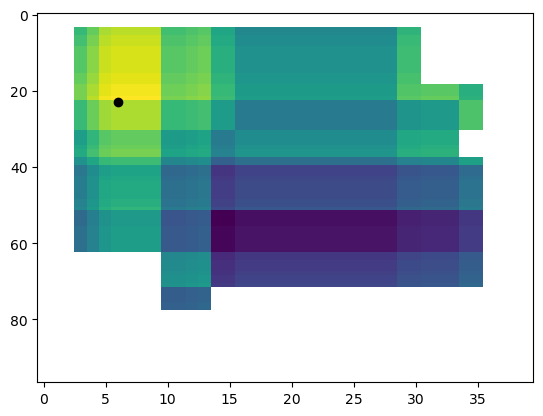

In [ ]:
import matplotlib.pyplot as plt
print(idx, len(dphis),len(sizes))
# plt.imshow(a_mc_scan.T[::-1,:], aspect='auto')
# plt.imshow(np.log(a_mc_scan.T[::-1,:]), aspect='auto')
# plt.imshow(ape_r3_scan.T[::-1,:], aspect='auto')
# plt.imshow(np.log(ape_r3_scan.T[::-1,:]), aspect='auto')
# plt.imshow(s2bs.T[::-1,:], aspect='auto')
plt.imshow(np.log(s2bs.T[::-1,:]), aspect='auto')
# plt.imshow(limits.T[::-1,:], aspect='auto')
# plt.imshow(np.log(limits.T[::-1,:]), aspect='auto')
plt.scatter([idx[0]], [len(sizes)-idx[1]], c='k')

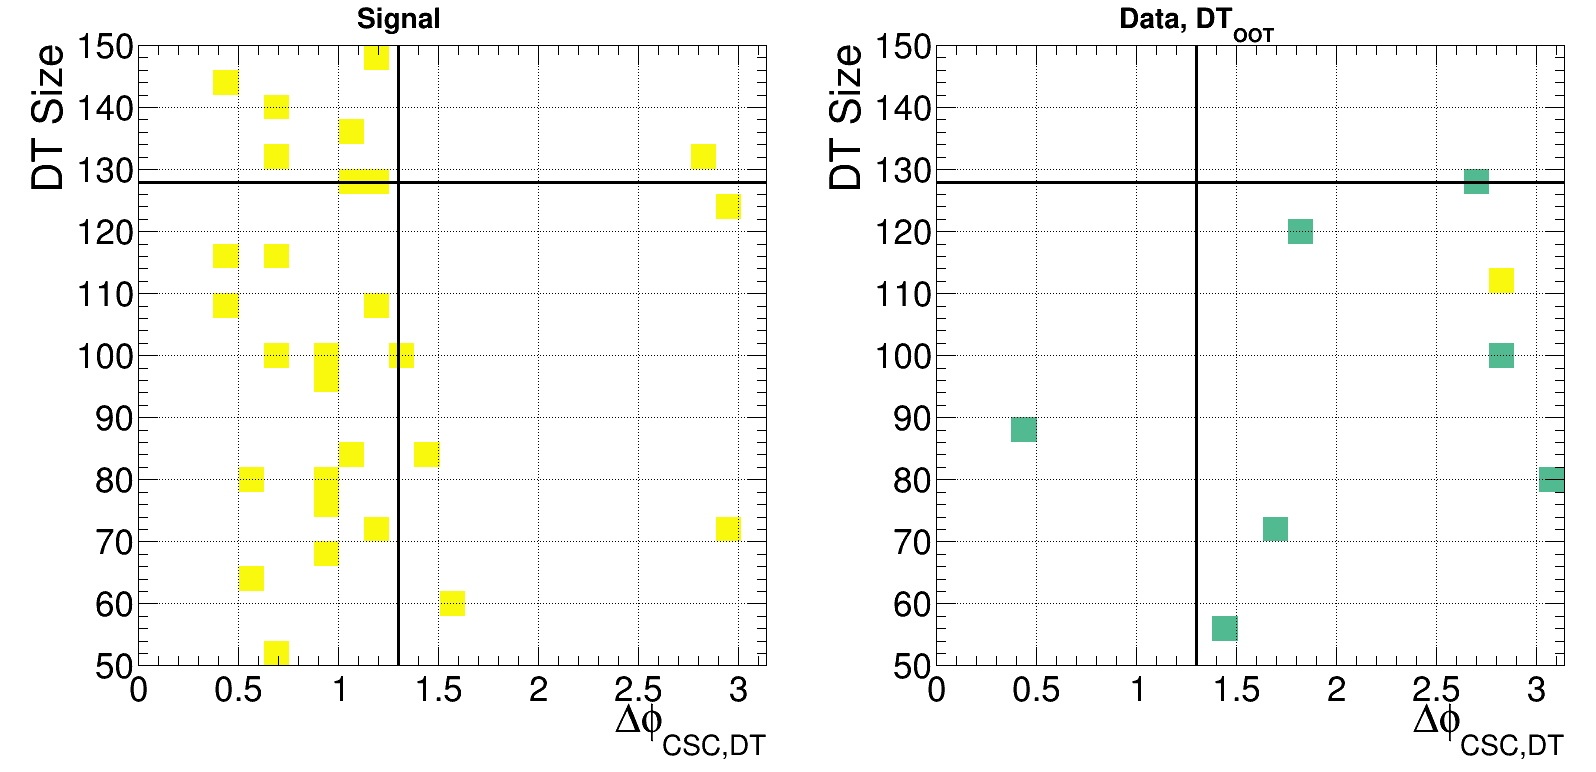

In [ ]:
canvas = TCanvas('','',2*800,800)
canvas.Divide(2,1)

dopt = ('col','box')[0]
nb = 25

form = ('',f';#Delta#phi_{{CSC,{SIZE_VAR.upper()}}};{SIZE_VAR.upper()} Size;count',nb,0,np.pi,nb,50,150)

dphi_line = TLine(ABCD_DPHI,50,ABCD_DPHI,150)
size_line = TLine(0,ABCD_SIZE,np.pi,ABCD_SIZE)
dphi_line.SetLineWidth(3)
size_line.SetLineWidth(3)

if 'high' in FN_R3:
    sr_box = TBox(0, ABCD_SIZE, ABCD_DPHI, 150)
else:# 'low' in FN_R3:
    sr_box = TBox(ABCD_DPHI, ABCD_SIZE, np.pi, 150)
sr_box.SetFillColor(rt.kBlack)

latex = TLatex()
latex.SetTextAlign(23)
latex.SetTextSize(0.04)

canvas.cd(1).SetGrid()
h_mc = rdfs['mc'].Histo2D(form,'tag_dPhi','tag_size').GetValue()
h_mc.Draw(dopt)

dphi_line.Draw()
size_line.Draw()
latex.DrawLatexNDC(0.5, 1, 'Signal'+(f', {SIZE_VAR.upper()}_{{OOT}}' if 'OOT' in FN_MC else ''))

canvas.cd(2).SetGrid()
h_r3 = rdfs['r3'].Histo2D(form,'tag_dPhi','tag_size').GetValue()
h_r3.Draw(dopt)

dphi_line.Draw()
size_line.Draw()
latex.DrawLatexNDC(0.5, 1, 'Data'+(f', {SIZE_VAR.upper()}_{{OOT}}' if 'OOT' in FN_R3 else ''))
if 'OOT' not in FN_R3:
    sr_box.Draw()

canvas.Draw()

#  Size Closure

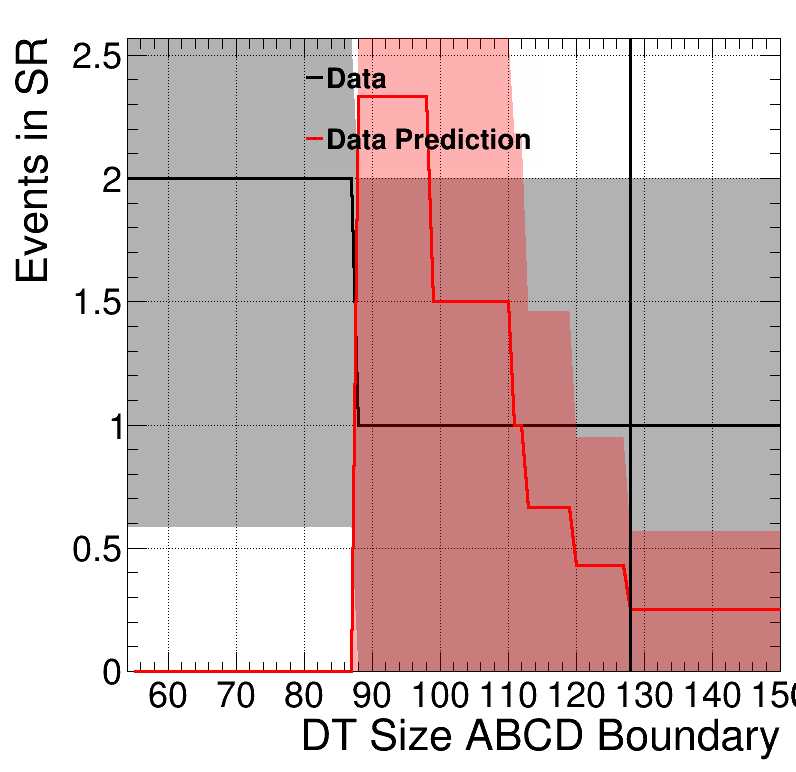

In [ ]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()
# canvas.SetLogy()

legend = TLegend(0.38, 0.78, 0.68, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.1)

# sizes = np.linspace(50,150,100)

if 'high' in FN_MC:
    a_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]
    b_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    c_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    d_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]

    a_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]
    b_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    c_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    d_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]
else:
    a_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]
    b_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    c_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    d_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]

    a_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]
    b_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    c_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size < {sz})').Sum('weight') for sz in sizes]
    d_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {ABCD_DPHI}) && (tag_size >= {sz})').Sum('weight') for sz in sizes]

a_mc = np.array([x.GetValue() for x in a_mc])
b_mc = np.array([x.GetValue() for x in b_mc])
c_mc = np.array([x.GetValue() for x in c_mc])
d_mc = np.array([x.GetValue() for x in d_mc])

a_r3 = np.array([x.GetValue() for x in a_r3])
b_r3 = np.array([x.GetValue() for x in b_r3])
c_r3 = np.array([x.GetValue() for x in c_r3])
d_r3 = np.array([x.GetValue() for x in d_r3])

ap_mc = np.array([b*d/c if c else -1 for b,c,d in zip(b_mc,c_mc,d_mc)])
ap_r3 = np.array([b*d/c if c else -1 for b,c,d in zip(b_r3,c_r3,d_r3)])

ae_mc = np.sqrt(a_mc)
ae_r3 = np.sqrt(a_r3)
ape_mc = np.array([a*(1/b+1/c+1/d)**(1/2) if b and c and d else 0 for a,b,c,d in zip(ap_mc,b_mc,c_mc,d_mc)])
ape_r3 = np.array([a*(1/b+1/c+1/d)**(1/2) if b and c and d else 0 for a,b,c,d in zip(ap_r3,b_r3,c_r3,d_r3)])

# **** #
xx = sizes
xlabel, ylabel = f'{SIZE_VAR.upper()} Size ABCD Boundary', 'Events in SR'

values = [[a_r3,ae_r3],[ap_r3,ape_r3]]#,[a_mc,ae_mc],[ap_mc,ape_mc]]
names = ['Data', 'Data Prediction']#,'Signal', 'Signal Prediction',]

hmin, hmax = 0, 1.1*max([max(v[0]) for v in values])
# hmin, hmax = 1e-9, 1.1*max([max(v[0]) for v in values])
for igr, (vv, ve) in enumerate(values):
    # if 'median' in ylabel.lower():
    #     yy = np.array([[np.median(v),np.median(v)-np.percentile(v,25),np.percentile(v,75)-np.median(v)] if len(v) else [0,0,0] for v in val])
    # elif 'mean' in ylabel.lower():
    #     yy = np.array([[v.mean(),v.mean()-np.percentile(v,25),np.percentile(v,75)-v.mean()] if len(v) else [0,0,0] for v in val])
    gr = TGraphErrors(len(xx),xx*1.,vv*1.,xx*0.,ve*1.)
    gr.GetXaxis().SetLimits(np.min(xx), np.max(xx))
    gr.SetMinimum(hmin)
    gr.SetMaximum(hmax)
    gr.SetName(names[igr])
    gr.GetXaxis().SetTitle(xlabel)
    gr.GetYaxis().SetTitle(ylabel)

    gr.SetLineWidth(3)
    gr.SetLineColor(SCL[igr])
    # gr.SetLineColor(SCL[0 if 'Signal' in names[igr] else 1])
    gr.SetLineStyle(rt.kDashed if '<' in names[igr] else rt.kSolid)
    gr.SetFillColorAlpha(gr.GetLineColor(), 0.3)
    gr.Draw(('' if igr else 'A')+' L3')
    legend.AddEntry(gr,gr.GetName(),'LP')
    gc.append(gr)

size_line = TLine(ABCD_SIZE,0,ABCD_SIZE,hmax)
size_line.Draw()
size_line.SetLineWidth(3)

legend.Draw()
canvas.Draw()


In [ ]:
# table
idx0 = np.argwhere(sizes == ABCD_SIZE)[0][0]
print(r'\begin{center}')
print(r'\begin{tabular}{c|cccc|c}')
print(r'    \hline')
print(f'    \\textbf{{{SIZE_VAR.upper()} Size}} & D & C & B & A & $A_{{pred}}=\\frac{{B \\cdot D}}{{C}}$ \\\\')
print(r'    \hline\hline')
for i in range(idx0-3, idx0+4):
    print(f'    {sizes[i]:.0f} & {d_r3[i]:.0f} & {c_r3[i]:.0f} & {b_r3[i]:.0f} & {a_r3[i]:.0f} ($\pm$ {a_r3[i]**0.5:.2f}) & {ap_r3[i]:.2f} ($\pm$ {ape_r3[i]:.2f}) \\\\')
    if i-idx0 in (-1, 0):
        print(r'    \hline')
print(r'\end{tabular}')
print(r'\end{center}')

\begin{center}
\begin{tabular}{c|cccc|c}
    \hline
    \textbf{DT Size} & D & C & B & A & $A_{pred}=\frac{B \cdot D}{C}$ \\
    \hline\hline
    125 & 3 & 7 & 1 & 1 ($\pm$ 1.00) & 0.43 ($\pm$ 0.52) \\
    126 & 3 & 7 & 1 & 1 ($\pm$ 1.00) & 0.43 ($\pm$ 0.52) \\
    127 & 3 & 7 & 1 & 1 ($\pm$ 1.00) & 0.43 ($\pm$ 0.52) \\
    \hline
    128 & 2 & 8 & 1 & 1 ($\pm$ 1.00) & 0.25 ($\pm$ 0.32) \\
    \hline
    129 & 2 & 8 & 1 & 1 ($\pm$ 1.00) & 0.25 ($\pm$ 0.32) \\
    130 & 2 & 8 & 1 & 1 ($\pm$ 1.00) & 0.25 ($\pm$ 0.32) \\
    131 & 2 & 8 & 1 & 1 ($\pm$ 1.00) & 0.25 ($\pm$ 0.32) \\
\end{tabular}
\end{center}


# deltaPhi Closure

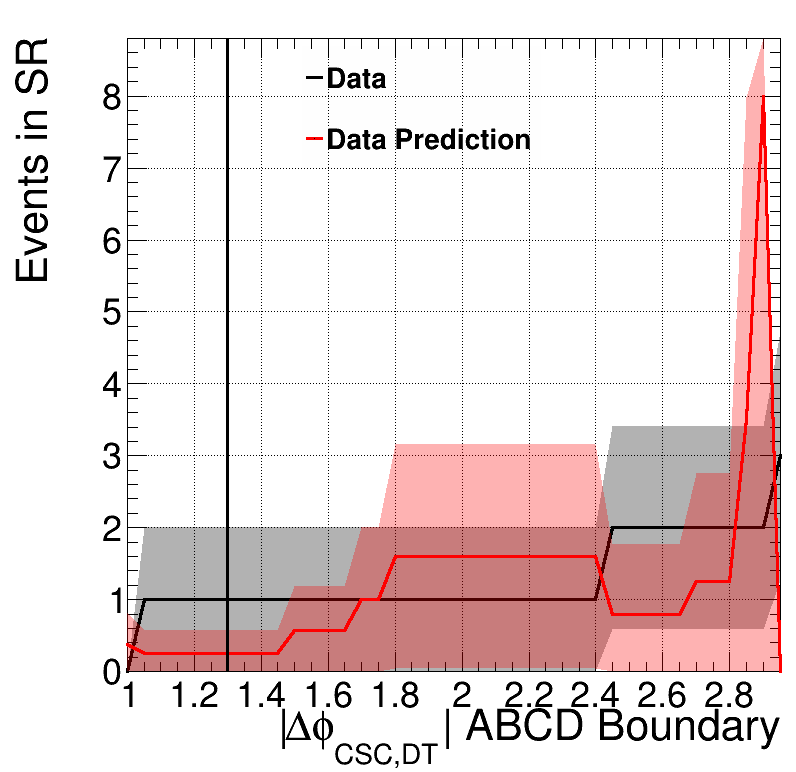

In [ ]:
canvas = TCanvas('','',800,800)
canvas.SetGrid()
# canvas.SetLogy()

legend = TLegend(0.38, 0.78, 0.68, 0.94)
legend.SetBorderSize(0)
legend.SetFillColorAlpha(rt.kBlack, 0)#0.2)
legend.SetTextSize(0.04)
legend.SetMargin(0.1)

# dphis = np.linspace(0.4,np.pi,100)

if 'high' in FN_MC:
    a_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]
    b_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    c_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    d_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]

    a_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]
    b_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    c_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    d_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]
else:
    a_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]
    b_mc = [rdfs['mc'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    c_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    d_mc = [rdfs['mc'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]

    a_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]
    b_r3 = [rdfs['r3'].Filter(f'(tag_dPhi >= {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    c_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size < {ABCD_SIZE})').Sum('weight') for dp in dphis]
    d_r3 = [rdfs['r3'].Filter(f'(tag_dPhi < {dp}) && (tag_size >= {ABCD_SIZE})').Sum('weight') for dp in dphis]

a_mc = np.array([x.GetValue() for x in a_mc])
b_mc = np.array([x.GetValue() for x in b_mc])
c_mc = np.array([x.GetValue() for x in c_mc])
d_mc = np.array([x.GetValue() for x in d_mc])

a_r3 = np.array([x.GetValue() for x in a_r3])
b_r3 = np.array([x.GetValue() for x in b_r3])
c_r3 = np.array([x.GetValue() for x in c_r3])
d_r3 = np.array([x.GetValue() for x in d_r3])

ap_mc = np.array([b*d/c if c else -1 for b,c,d in zip(b_mc,c_mc,d_mc)])
ap_r3 = np.array([b*d/c if c else -1 for b,c,d in zip(b_r3,c_r3,d_r3)])

ae_mc = np.sqrt(a_mc)
ae_r3 = np.sqrt(a_r3)
ape_mc = np.array([a*(1/b+1/c+1/d)**(1/2) if b and c and d else 0 for a,b,c,d in zip(ap_mc,b_mc,c_mc,d_mc)])
ape_r3 = np.array([a*(1/b+1/c+1/d)**(1/2) if b and c and d else 0 for a,b,c,d in zip(ap_r3,b_r3,c_r3,d_r3)])

# **** #
xx = dphis
xlabel, ylabel = f'|#Delta#phi_{{CSC,{SIZE_VAR.upper()}}}| ABCD Boundary', 'Events in SR'

values = [[a_r3,ae_r3],[ap_r3,ape_r3]]#,[a_mc,ae_mc],[ap_mc,ape_mc]]
names = ['Data', 'Data Prediction']#,'Signal', 'Signal Prediction',]

hmin, hmax = 0, 1.1*max([max(v[0]) for v in values])
for igr, (vv, ve) in enumerate(values):
    # if 'median' in ylabel.lower():
    #     yy = np.array([[np.median(v),np.median(v)-np.percentile(v,25),np.percentile(v,75)-np.median(v)] if len(v) else [0,0,0] for v in val])
    # elif 'mean' in ylabel.lower():
    #     yy = np.array([[v.mean(),v.mean()-np.percentile(v,25),np.percentile(v,75)-v.mean()] if len(v) else [0,0,0] for v in val])
    gr = TGraphErrors(len(xx),xx*1.,vv*1.,xx*0.,ve*1.)
    gr.GetXaxis().SetLimits(np.min(xx), np.max(xx))
    gr.SetMinimum(hmin)
    gr.SetMaximum(hmax)
    gr.SetName(names[igr])
    gr.GetXaxis().SetTitle(xlabel)
    gr.GetYaxis().SetTitle(ylabel)

    gr.SetLineWidth(3)
    gr.SetLineColor(SCL[igr])
    # gr.SetLineColor(SCL[0 if 'Signal' in names[igr] else 1])
    gr.SetLineStyle(rt.kDashed if '<' in names[igr] else rt.kSolid)
    gr.SetFillColorAlpha(gr.GetLineColor(), 0.3)
    gr.Draw(('' if igr else 'A')+' L3')
    legend.AddEntry(gr,gr.GetName(),'LP')
    gc.append(gr)

dphi_line = TLine(ABCD_DPHI,0,ABCD_DPHI,hmax)
dphi_line.Draw()
dphi_line.SetLineWidth(3)

legend.Draw()
canvas.Draw()


In [ ]:
# table
idx0 = np.argwhere(dphis == ABCD_DPHI)[0][0]
print(r'\begin{center}')
print(r'\begin{tabular}{c|cccc|c}')
print(r'    \hline')
print(f'    $\\mathbf{{|\\Delta\\phi_{{CSC,{SIZE_VAR.upper()}}}|}}$ & D & C & B & A & $A_{{pred}}=\\frac{{B \\cdot D}}{{C}}$ \\\\')
print(r'    \hline\hline')
for i in range(idx0-3, idx0+4):
    print(f'    {dphis[i]:.2f} & {d_r3[i]:.0f} & {c_r3[i]:.0f} & {b_r3[i]:.0f} & {a_r3[i]:.0f} ($\pm$ {a_r3[i]**0.5:.2f}) & {ap_r3[i]:.2f} ($\pm$ {ape_r3[i]:.2f}) \\\\')
    if i-idx0 in (-1, 0):
        print(r'    \hline')
print(r'\end{tabular}')
print(r'\end{center}')

\begin{center}
\begin{tabular}{c|cccc|c}
    \hline
    $\mathbf{|\Delta\phi_{CSC,DT}|}$ & D & C & B & A & $A_{pred}=\frac{B \cdot D}{C}$ \\
    \hline\hline
    1.15 & 2 & 8 & 1 & 1 ($\pm$ 1.00) & 0.25 ($\pm$ 0.32) \\
    1.20 & 2 & 8 & 1 & 1 ($\pm$ 1.00) & 0.25 ($\pm$ 0.32) \\
    1.25 & 2 & 8 & 1 & 1 ($\pm$ 1.00) & 0.25 ($\pm$ 0.32) \\
    \hline
    1.30 & 2 & 8 & 1 & 1 ($\pm$ 1.00) & 0.25 ($\pm$ 0.32) \\
    \hline
    1.35 & 2 & 8 & 1 & 1 ($\pm$ 1.00) & 0.25 ($\pm$ 0.32) \\
    1.40 & 2 & 8 & 1 & 1 ($\pm$ 1.00) & 0.25 ($\pm$ 0.32) \\
    1.45 & 2 & 8 & 1 & 1 ($\pm$ 1.00) & 0.25 ($\pm$ 0.32) \\
\end{tabular}
\end{center}
